Update :
    Ajout de DataAugmentation

In [1]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob

## Load model

In [2]:
model = keras.models.load_model('A:\\fingers.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [3]:
x = model.layers[-2].output

In [4]:
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>

In [5]:
output = Dense(units=3, activation='softmax')(x)

In [6]:
model = Model(inputs=model.input, outputs=output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Load Data

In [8]:
from tqdm import tqdm
import random
def load(set: str):
    xtrain = []
    ytrain = []
    print(set)
    train_num_files = 0
    for source in ["Temps1", "Temps2", "Temps3"]:
        print(source)
        file_list = glob.glob(
            r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
        if source == "Temps0":
            file_list = random.choices(file_list, k=200)
        # print(len(file_list))
        for file in tqdm(file_list, desc="Loading..."):
            p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
            file_label = p + file[len(p):]
            file_label = file_label[:-4]
            file_label = file_label+'.txt'
            if os.path.isfile(file_label):
                f = open(file_label,"r+")
                a = f.read()
                if len(a)>=1:
                    im = imread(file)[:, :, :3]
                    train_num_files += 1
                    xtrain.append(im)
                    ytrain.append([int(a[0])])
                f.close()
    return xtrain, ytrain

xtrain, ytrain = load("train")
xval, yval = load("val")
xtest, ytest = load("test")
# xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

train
Temps1


Loading...: 100%|██████████| 519/519 [00:01<00:00, 457.68it/s]


Temps2


Loading...: 100%|██████████| 448/448 [00:01<00:00, 417.47it/s]


Temps3


Loading...: 100%|██████████| 326/326 [00:00<00:00, 385.87it/s]


val
Temps1


Loading...: 100%|██████████| 54/54 [00:00<00:00, 401.07it/s]


Temps2


Loading...: 100%|██████████| 310/310 [00:00<00:00, 394.95it/s]


Temps3


Loading...: 100%|██████████| 71/71 [00:00<00:00, 355.95it/s]


test
Temps1


Loading...: 100%|██████████| 31/31 [00:00<00:00, 341.50it/s]


Temps2


Loading...: 100%|██████████| 321/321 [00:00<00:00, 374.25it/s]


Temps3


Loading...: 100%|██████████| 181/181 [00:00<00:00, 364.43it/s]


In [9]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [10]:
def f1_score(y_true, y_pred):
	def recall_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

		recall = TP / (Positives+K.epsilon())
		return recall


	def precision_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

		precision = TP / (Pred_Positives+K.epsilon())
		return precision

	precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

	return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [12]:
from keras.utils import to_categorical

In [13]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

## Data augmentation

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=60,
    width_shift_range=0.2,
	height_shift_range=0.2,
	# brightness_range=(-1, 1),
	zoom_range=(0.33,1.3),
    horizontal_flip=True,
    # validation_split=0.1
)

In [15]:
random.seed(42)
datagen.fit(xtrain)

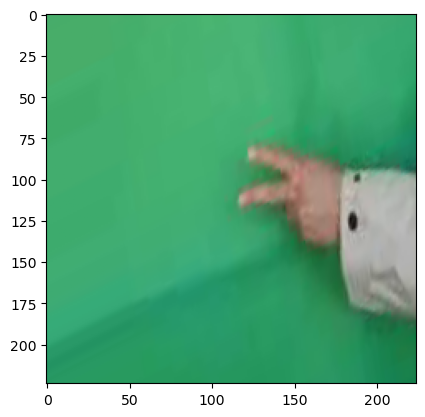

In [16]:
plt.imshow(datagen.random_transform(xtrain[350], seed=42))

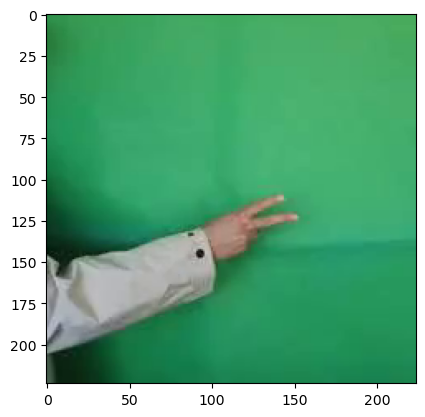

In [17]:
plt.imshow(xtrain[350])

In [18]:
import sys
sys.getsizeof(xtrain)

777326744

## Train

In [19]:

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=10),
		  # model.fit(train_gen,
		  validation_data=datagen.flow(xval, yval, batch_size=10),
		  batch_size=10,
		  steps_per_epoch=len(xtrain) // 10,
		  epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.6066 - f1_score: 0.5937
Epoch 1: val_loss improved from inf to 1.06396, saving model to shifumi_from_mobil.hdf5
129/129 [==============================] - 23s 138ms/step - loss: 0.9080 - accuracy: 0.6066 - f1_score: 0.5937 - val_loss: 1.0640 - val_accuracy: 0.5379 - val_f1_score: 0.5233
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.7674 - f1_score: 0.7634
Epoch 2: val_loss did not improve from 1.06396
129/129 [==============================] - 16s 123ms/step - loss: 0.5998 - accuracy: 0.7674 - f1_score: 0.7634 - val_loss: 1.2349 - val_accuracy: 0.6414 - val_f1_score: 0.6322
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8025 - f1_score: 0.7996
Epoch 3: val_loss did not improve from 1.06396
129/129 [==============================] - 16s 120ms/step - loss: 0.4523 - accuracy: 0.8025 - f1_score: 0.7996 - val_loss

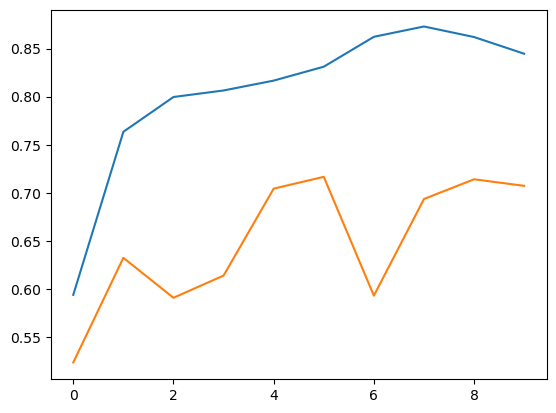

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.show()

In [21]:
model.evaluate(xtest, ytest)

17/17 [==============================] - 1s 42ms/step - loss: 0.6335 - accuracy: 0.7917 - f1_score: 0.7807


[0.63346266746521, 0.7917448282241821, 0.780735433101654]